In [1]:
import numpy as np
import pandas as pd
import plot_util
import seaborn as sns

from matplotlib import pyplot as plt

In [2]:
long_nosc_df = pd.read_csv('../data/genomes/all_ref_prot_NOSC.csv')
long_nosc_df.head()

,aa_seq,num_aas,NC,Ce,NOSC,mw_daltons,transmembrane_aas,transmembrane_Cs,fraction_transmembrane,fraction_transmembrane_C,...,GO_terms,COG_IDs,KEGG_IDs,isoform_accessions,KEGG_path_IDs,KEGG_pathways,eC_ratio,organism,primary_COG_category,secondary_COG_category
0,MRLHVKLKEFLSMFFMAILFFPAFNASLFFTGVKPLYSIIKCSTEI...,159,862.0,-301.25,-0.349478,18118.0,60.0,345.0,0.377358,0.400232,...,"GO:0016020,GO:0006974,GO:0046677",ENOG5031M8I,eco:b4586,NaN,NaN,NaN,4.349478,coli,NaN,NaN
1,MTLDLPRRFPWPTLLSVCIHGAVVAGLLYTSVHQVIELPAPAQPIS...,239,1173.0,-244.16,-0.208150,26094.0,31.0,159.0,0.129707,0.135550,...,"GO:0030313,GO:0009279,GO:0030288,GO:0005886,GO...",COG0810,"ecj:JW5195,eco:b1252",NaN,NaN,NaN,4.208150,coli,M,NaN
2,MPELPEVETSRRGIEPHLVGATILHAVVRNGRLRWPVSEEIYRLSD...,269,1358.0,-231.79,-0.170685,30290.0,0.0,0.0,0.000000,0.000000,...,"GO:0034039,GO:0140078,GO:0003684,GO:0019104,GO...",COG0266,"ecj:JW3610,eco:b3635",NaN,path:eco03410,Base excision repair - Escherichia coli K-12 M...,4.170685,coli,L,NaN
3,MSIVMQLQDVAESTRLGPLSGEVRAGEILHLVGPNGAGKSTLLARM...,249,1189.0,-157.82,-0.132733,27081.0,0.0,0.0,0.000000,0.000000,...,"GO:0043190,GO:1990191,GO:0019898,GO:0015420,GO...",COG4138,"ecj:JW1699,eco:b1709",NaN,path:eco02010,ABC transporters - Escherichia coli K-12 MG1655,4.132733,coli,H,NaN
4,MSENKLNVIDLHKRYGEHEVLKGVSLQANAGDVISIIGSSGSGKST...,257,1266.0,-201.82,-0.159415,28653.0,0.0,0.0,0.000000,0.000000,...,"GO:0055052,GO:0015424,GO:0005524,GO:0005291,GO...",COG4598,"ecj:JW2303,eco:b2306",NaN,path:eco02010,ABC transporters - Escherichia coli K-12 MG1655,4.159415,coli,E,NaN


In [3]:
# Monte Carlo sampling to estimate plausible range of proteome NOSC
eq_weight_estimates = dict(organism=[], NOSC=[], eC_ratio=[])
weighted_estimates = dict(organism=[], NOSC=[], eC_ratio=[])
# estimate a range on the coding sequence NOSC
cols2sum = 'NC,Ce'.split(',')
rows_mask = long_nosc_df[cols2sum].notnull().all(axis=1)


# For each organism, we sample 1000 genes across 5 orders of expression
# 1e5 times and record the NOSC of the samples. We also make an unweighted 
# estimate, but they should have the same mean. 
for gid, gdf in long_nosc_df.loc[rows_mask].groupby('organism'):
    print(gid)
    for _ in range(10000):
        # In E. coli, 1000 genes covers ≈99% of protein C atoms
        sample = gdf.sample(1000)
        s = sample[cols2sum].sum()
        
        sample_nosc = s.Ce / s.NC

        eq_weight_estimates['organism'].append(gid)
        eq_weight_estimates['NOSC'].append(sample_nosc)
        eq_weight_estimates['eC_ratio'].append(4 - sample_nosc)
        
        # sample expression from a log-normal with a std deviation of 3 orders
        # SET THE STD DEVIATION
        expression = np.random.lognormal(size=1000)
        Ce_weighted = sample.Ce * expression
        NC_weighted = sample.NC * expression
        sample_nosc_weighted = Ce_weighted.sum() / NC_weighted.sum()
        
        weighted_estimates['organism'].append(gid)
        weighted_estimates['NOSC'].append(sample_nosc_weighted)
        weighted_estimates['eC_ratio'].append(4 - sample_nosc_weighted)
        
eq_weight_nosc_est_df = pd.DataFrame(eq_weight_estimates)
eq_weight_nosc_est_df.to_csv('../data/genomes/all_ref_prot_NOSC_unweighted_monte_carlo_samples.csv', index=False)
weighted_nosc_est_df = pd.DataFrame(weighted_estimates)
weighted_nosc_est_df.to_csv('../data/genomes/all_ref_prot_NOSC_weighted_monte_carlo_samples.csv', index=False)

PCC6803
coli
yeast


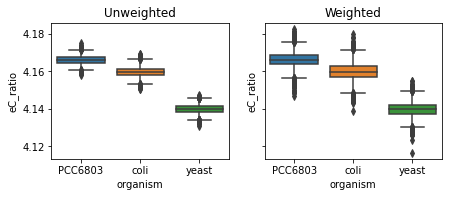

In [4]:
# Compare the weighted and unweighted samples
fig, axs = plt.subplots(ncols=2, figsize=(7,2.5), sharey=True)

plt.sca(axs[0])
sns.boxplot(data=eq_weight_nosc_est_df, x='organism', y='eC_ratio')
plt.title('Unweighted')

plt.sca(axs[1])
plt.title('Weighted')
sns.boxplot(data=weighted_nosc_est_df, x='organism', y='eC_ratio')

plt.show()